## Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.figure import Figure
from scipy.signal import correlate
from scipy.stats import zscore
import numpy as np
import datetime as dt

# Read the data from the csv file
df = pd.read_csv('HEL_12-10-21to08-11-23.csv')
print(df.head())
print(df.describe())

                  date   REG1V.HE   NESTE.HE   ORNBV.HE   KNEBV.HE   OLVAS.HE  \
0  2021-10-12 07:00:00  55.950001  41.820000  35.689999  60.220001  53.099998   
1  2021-10-12 08:00:00  55.799999  41.720001  35.630001  60.419998  53.299999   
2  2021-10-12 09:00:00  55.700001  42.060001  35.400002  60.200001  53.200001   
3  2021-10-12 10:00:00  55.450001  42.009998  35.500000  60.119999  52.900002   
4  2021-10-12 11:00:00  56.000000  42.000000  35.680000  60.480000  52.599998   

    HUH1V.HE   DETEC.HE   ORNAV.HE   CGCBV.HE   VAIAS.HE   ALBBV.HE  \
0  38.529999  23.000000  38.049999  43.139999  46.150002  28.700001   
1  38.560001  23.000000  38.049999  43.500000  45.950001  28.799999   
2  38.349998  23.000000  38.049999  43.619999  45.849998  28.600000   
3  38.220001  23.200001  38.049999  43.480000  45.700001  28.500000   
4  38.349998  23.200001  38.000000  43.279999  45.650002  28.700001   

    VALMT.HE   EQV1V.HE   PON1V.HE  
0  36.459999  24.850000  39.150002  
1  36.599998

## Exploratory Data Analysis

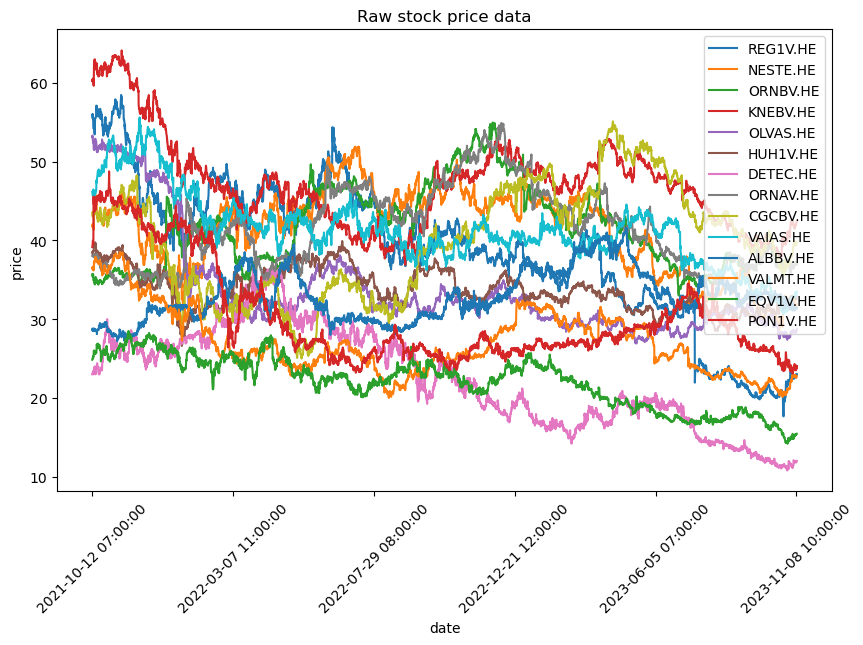

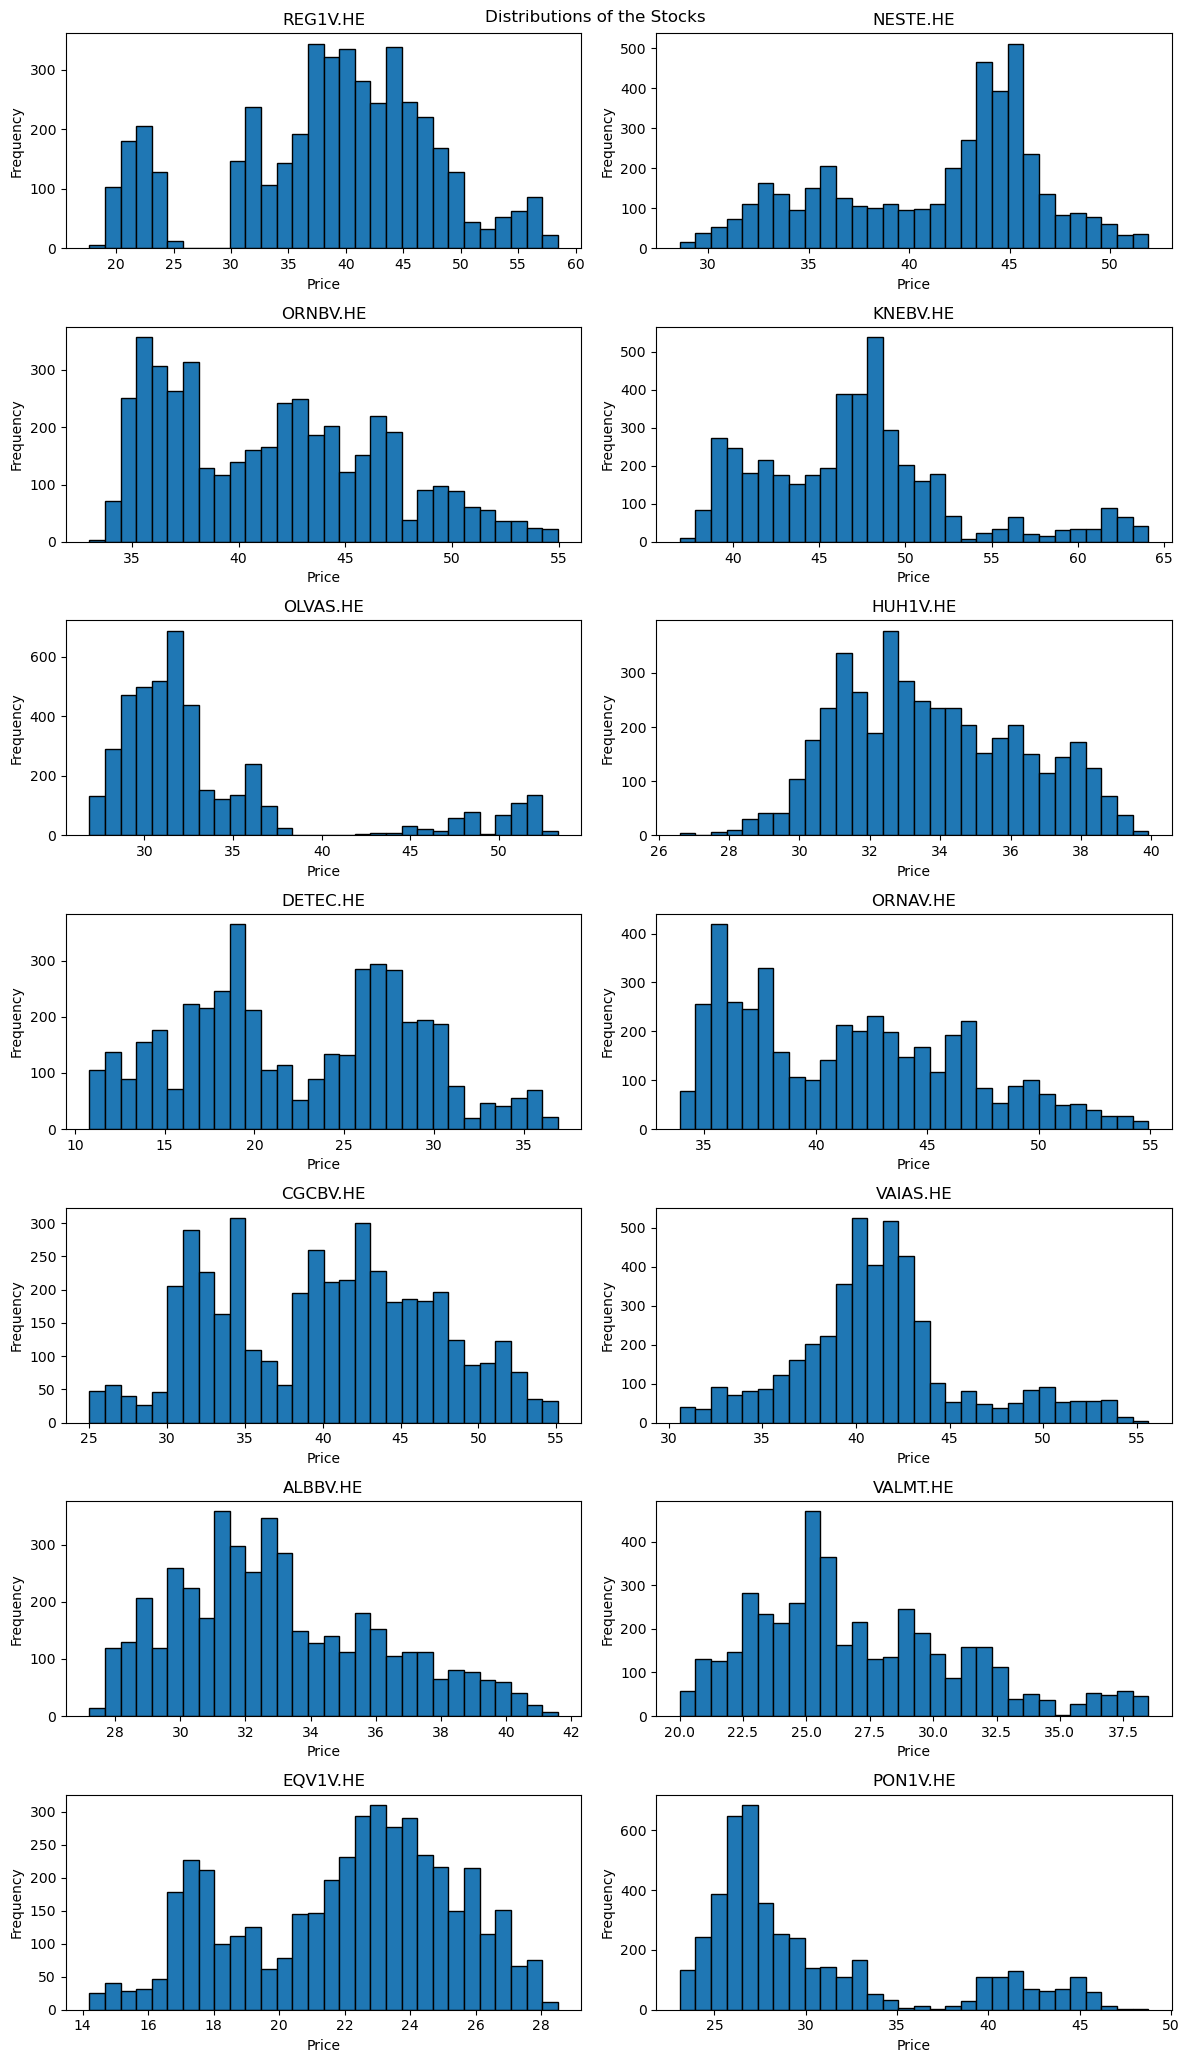

In [2]:
df_custom = df.set_index("date")

fig, ax = plt.subplots(figsize=(10, 6))

df_custom.plot(ax=ax)

num_ticks = 5
xticks_idx = range(0, len(df_custom), len(df_custom)//num_ticks)
plt.xticks(xticks_idx, df_custom.index[xticks_idx].values, rotation=45)

plt.title('Raw stock price data')
plt.xlabel('date')
plt.ylabel('price')

fig.savefig("./figures/raw.svg")

num_columns = len(df_custom.columns)

# Calculate how many rows and columns for subplot
num_rows = (num_columns + 1) // 2  # Add 1 to round up for odd numbers
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 3 * num_rows))

for i, column in enumerate(df_custom.columns):
    row_index = i // num_cols
    col_index = i % num_cols
    ax = axes[row_index, col_index] if num_rows > 1 else axes[col_index]

    
    ax.hist(df_custom[column], bins=30, edgecolor='black')
    ax.set_title(f'{column}')
    ax.set_xlabel('Price')
    ax.set_ylabel('Frequency')

plt.suptitle('Distributions of the Stocks', )

plt.tight_layout()
plt.show()

fig.savefig("./figures/distributions.svg")

## Instant Cross-Correlation

## Time Auto-Correlation

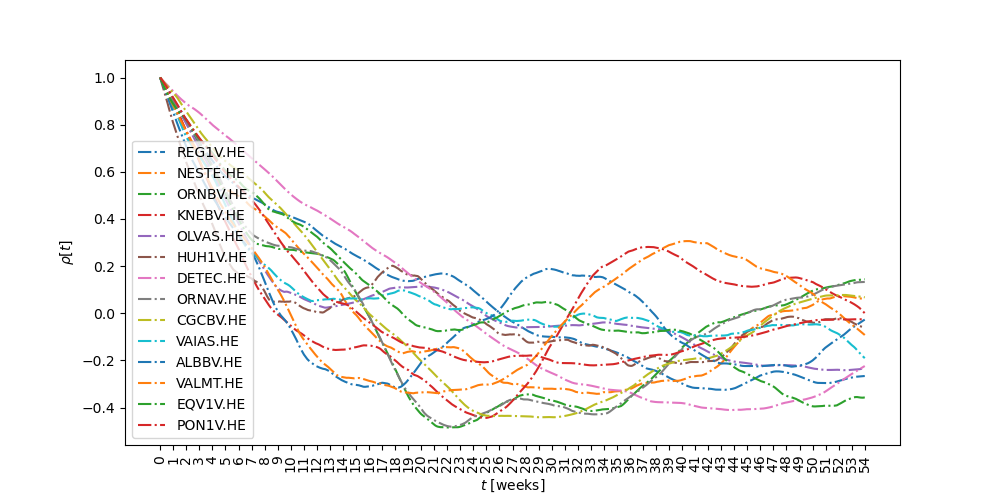

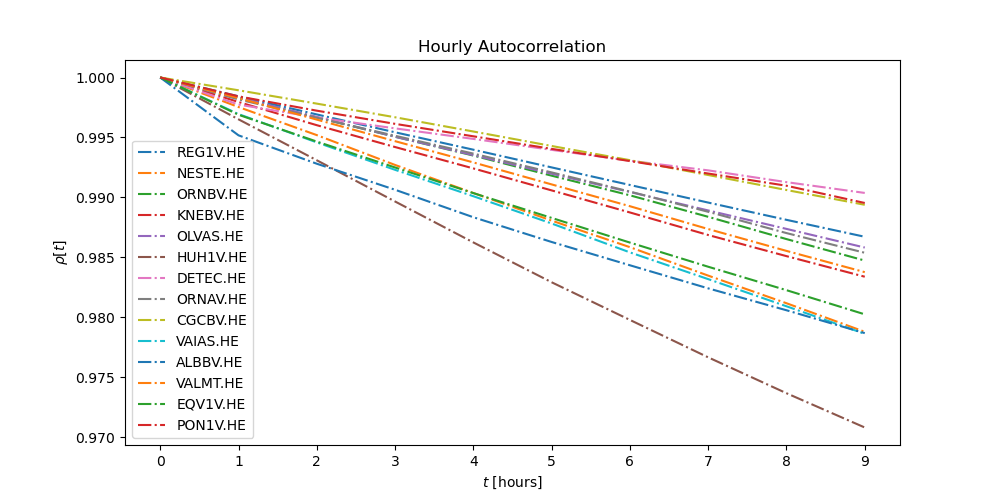

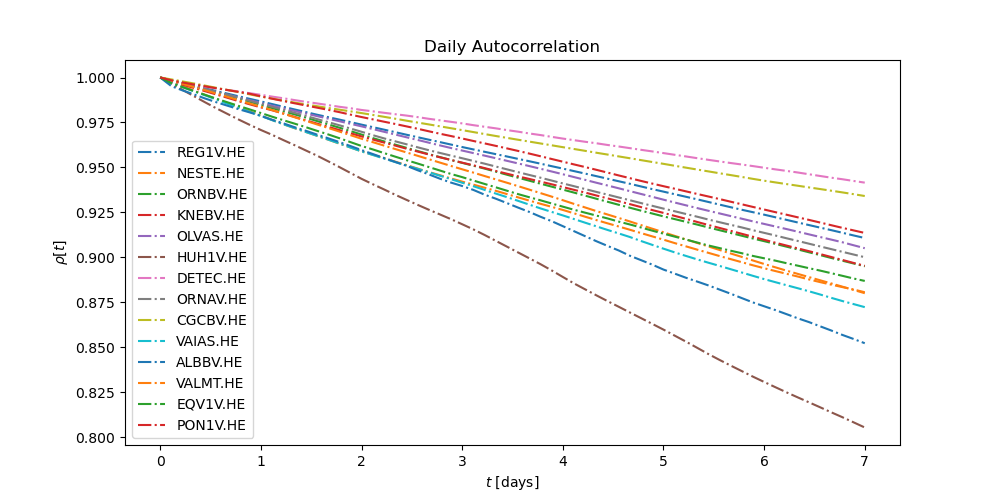

In [3]:
%matplotlib widget
df_custom = df.set_index("date")

def plot_autocorr(df_internal:pd.DataFrame, stop:int, step:int) -> Figure:
    fig = plt.figure(figsize=(10,5))

    for column in df_internal.columns:
        x = zscore(df_internal[column].to_numpy().flatten())
        x_acorr = correlate(x, x)[len(x)-1:] / (np.linalg.norm(x)**2)
        plt.plot(np.arange(start=0, stop=stop, step=step),
                 x_acorr[:stop:step], label=column, ls="-.")

    plt.gca().legend(loc="best")
    return fig
    

fig_hourly = plot_autocorr(df_custom, stop=1+9, step=1)
plt.xticks(np.arange(0,1+9,1), np.arange(0,1+9,1))
plt.xlabel(r"$t$ [hours]")
plt.ylabel(r"$\rho[t]$")
plt.title("Hourly Autocorrelation")
fig_hourly.savefig("./figures/acorr_hourly.svg")
#plt.close()

fig_daily= plot_autocorr(df_custom, stop=1+9*7, step=1)
plt.xticks(np.arange(0,1+9*7,9), np.arange(0,1+7))
plt.xlabel(r"$t$ [days]")
plt.ylabel(r"$\rho[t]$")
plt.title("Daily Autocorrelation")
fig_daily.savefig("./figures/acorr_daily.svg")
#plt.close()

fig_weekly = plot_autocorr(df_custom, stop=1+9*7*54, step=1)
plt.xticks(np.arange(0,1+9*7*54,9*7), np.arange(0,1+54), rotation=90)
plt.xlabel(r"$t$ [weeks]")
plt.ylabel(r"$\rho[t]$")
fig_weekly.savefig("./figures/acorr_weekly.svg")
#plt.close()
plt.show()

## Trend-Seasonality Decomposition

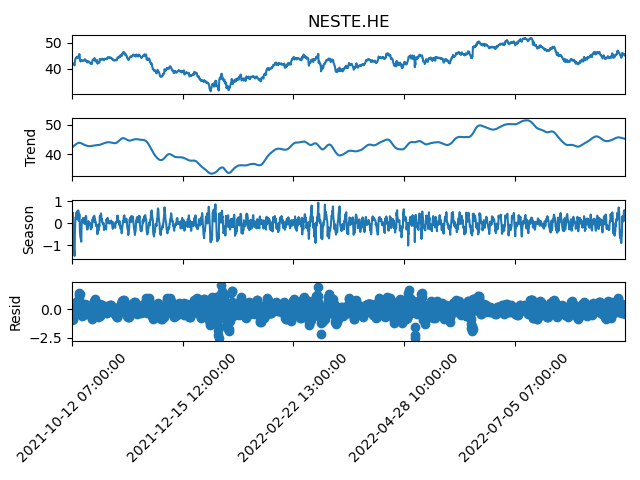

In [6]:
from statsmodels.tsa.seasonal import STL

stl = STL(df_custom['NESTE.HE'].head(2000), period=24)
res = stl.fit()
fig = res.plot()

xticks_idx = range(0, len(df_custom.head(2000)), len(df_custom.head(2000))//num_ticks)
plt.xticks(xticks_idx, df_custom.index[xticks_idx], rotation=45)
plt.tight_layout()
plt.show()

fig.savefig("./figures/seasonality.png")
#plt.close()